# Colossus Analysis

This notebook is an analysis of `colossus`, a 10-million-body globular cluster simulation run using Cluster Monte Carlo (CMC) code. We track hierarchical black hole mergers amongst `colossus` and the models of the `CMC Cluster Catalog` (Kremer et al. 2020), and extrapolate merger populations to Virgo Cluster GCs. For further context, see Mai et al. (2025).

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import random
import time
import bisect

In [11]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "font.size": 20,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "axes.linewidth": 2,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 18
})

Setup helper classes to keep track of black holes, mergers, CMC models, etc as objects

In [12]:
class BlackHole:
    def __init__(this, model, id, mass, spin, gen):
        this.model = model
        model.bhs[id] = this
        this.id = id
        this.mass = mass
        this.spin = spin
        this.gen = gen

    def __str__(this):
        a = f"BH {this.id} from model {this.model.id}: mass {this.mass}, spin {this.spin}, gen {this.gen}"
        if hasattr(this, "parent"):
            a += f", parent {this.parent.id}"
        if hasattr(this, "children"):
            a += f", children {str([bh.id for bh in this.children])}"
        return a

class MergeEvent:
    def __init__(this, model, bh1, bh2, bh3, channel, time):
        this.model = model
        this.bh1 = bh1
        this.bh2 = bh2
        this.bh3 = bh3
        this.channel = channel
        this.time = time
        
        bh1.merger = this
        bh2.merger = this
        bh3.children = (bh1, bh2)
        bh1.parent = bh3
        bh2.parent = bh3
        bh3.gen = max(bh1.gen, bh2.gen) + 1

        this.gen = bh3.gen - 1
        model.mergers.append(this)

    def __str__(this):
        return f"Merge between {this.bh1.id} and {this.bh2.id} from model {this.model.id}: {this.bh1.mass} Msun (gen {this.bh1.gen}) + {this.bh2.mass} Msun (gen {this.bh2.gen}) = {this.bh3.mass} Msun (gen {this.bh3.gen})"

class Model:
    def __init__(this, id, n, rv, rgc, z):
        this.id = id
        this.rv = rv
        this.rgc = rgc
        this.z = z
        this.n = n

        this.bhs = {}
        this.mergers = []

    def __str__(this):
        return f"Model {this.id}: N={this.n}, rv={this.rv}, Rgc={this.rgc}, Z={this.z}, BHs {len(this.bhs.keys())}, mergers {len(this.mergers)}"
    
    def getCurrentBh(this, bhId):
        # The id of the merger product is often the reused id of one of the progenitors. Given an old reused id, get the id of the merged BH it's actually referring to
        while bhId in this.bhs and hasattr(this.bhs[bhId], "merger"):
            bhId = this.bhs[bhId].merger.bh3.id
        return bhId
    
class VirgoGalaxy:
    def __init__(this, vccId, distance):
        this.vccId = vccId
        this.distance = distance    

class VirgoCluster:
    def __init__(this, id, mass, rh, galaxy):
        this.id = id
        this.mass = mass
        this.rh = rh
        this.hostGalaxy = galaxy

Helper function to read in data file. For example of params, see next cell

In [13]:
def readFile(filename, params):
    """
    Helper function to read in file. `params` is a dictionary of the form:
    {
        index: (paramName, paramType),
        ...
    }
    paramType can be float, int, or str
    Returns the list of lines, each line converted to a dict with paramName-s as keys
    """
    lines = []
    with open(filename) as file:
        for line in file.readlines():
            if line[0] == "#": continue
            lineSplit = line.split()
            lines.append({
                    param[0]: (param[1](float(lineSplit[index])) 
                                   if param[1] != str else lineSplit[index])
                              if index < len(lineSplit) else None
                    for index,param in params.items()
                })
    return lines

Read in data for CMC models. Instantiate `Model` objects with initial params, and get present-day params. Process merger files, creating `BlackHole` and `MergeEvent` objects to track hierarchical mergers.

In [14]:
cmcModels = {}

fileParams = {
    0: ("modelNum", int),
    1: ("N", int),
    2: ("rv", int),
    3: ("Rgc", int),
    4: ("Z", float)
}
# Create objects for CMC models with initial params file
for line in readFile("cmc_catalog/cluster_initial_params.dat", fileParams):
    modelNum,N,rv,Rgc,Z = line.values()
    cmcModels[modelNum] = Model(modelNum, N, rv, Rgc, Z)
    

fileParams = {
    0: ("modelNum", int),
    1: ("time", float),
    3: ("Ltot", float),
    4: ("M/L", float),
    11: ("rh", float)
}
# Read in mass and rh values for CMC models. File is sorted by time, so only the latest params stick
for line in readFile("cmc_catalog/cluster_params_all_final.dat", fileParams):
    modelNum,t,Ltot,MtoL,rh = line.values()
    if t > 12000:
        cmcModels[modelNum].mass = Ltot * MtoL
        cmcModels[modelNum].rh = rh
# Remove CMC models which don't have listed mass-rh values
for model in list(cmcModels.keys()):
    if not hasattr(cmcModels[model], "mass"):
        cmcModels.pop(model)

fileParams = {
    0: ("modelNum", int),
    5: ("mergerTime", float),
    6: ("id1", int),
    7: ("id2", int),
    8: ("m1", float),
    9: ("m2", float),
    10: ("spin1", float),
    11: ("spin2", float),
    12: ("gen1", int),
    13: ("gen2", int),
    16: ("channel", int),
    17: ("id3", int), # merger product
    18: ("m3", float),
    19: ("spin3", float),
    20: ("gen3", int)
}
# Process merger files
start = time.time()
for mergerFile in ["colossus/BBHmergers_colossus.dat", "cmc_catalog/BBHmergers_CMCcatalog.dat"]:
    for merger in readFile(mergerFile, fileParams):
        
        if merger["modelNum"] not in cmcModels: continue
        model = cmcModels[merger["modelNum"]]
        
        # id3 is often either id1 or id2 reused (or -1 if ejected), but we can't have duplicate IDs
        # Keep a flag to check if we need to generate a new id for the merger product
        needNewId3 = False
        if merger["id3"] in (merger["id1"], merger["id2"], -1):
            needNewId3 = True
        
        # If id1 or id2 are reused ids from previous mergers, get the current BH id that it's actually referring to
        merger["id1"] = model.getCurrentBh(merger["id1"])
        merger["id2"] = model.getCurrentBh(merger["id2"])
        
        # Generate new id3 if necessary, make sure new id doesn't collide with any existing BHs
        if needNewId3:
            merger["id3"] = merger["id1"] + merger["id2"]
        while merger["id3"] in model.bhs or merger["id3"] in (merger["id1"], merger["id2"], -1):
            merger["id3"] += 1
        
        # Create new BH objects if necessary and create the MergeEvent object
        bhObjects = []
        for num in ["1", "2", "3"]:
            bhId = merger[f"id{num}"]
            if bhId not in model.bhs:
                bhObjects.append(BlackHole(model, bhId, merger[f"m{num}"], merger[f"spin{num}"], merger[f"gen{num}"]))
            else:
                bhObjects.append(model.bhs[bhId])
        
        mergeObject = MergeEvent(model, bhObjects[0], bhObjects[1], bhObjects[2], merger["channel"], merger["mergerTime"])
        
# Some models were stopped due to onset of collisional runaway, and are excluded from the merger files. Remove these from analysis
# Also exclude models with Z > 0.1*Z_sun
for model in list(cmcModels.keys()):
    if len(cmcModels[model].mergers) == 0 or cmcModels[model].z > 0.1:
        cmcModels.pop(model)

print(f"{len(cmcModels)} models with {sum([len(model.mergers) for model in cmcModels.values()])} mergers processed in {'{:.4f}'.format(time.time() - start)}s")

81 models with 9597 mergers processed in 0.2785s


Plot primary vs secondary mass for all mergers in a CMC model, and color each point by generation.

In [42]:
def m1m2(model):
    """
    Scatterplot for primary-secondary mass of all BH mergers in a CMC model.
    Color each point by generation 1-4
    """
    
    plt.figure(figsize=(4.5,4))
    
    m1_values = []
    m2_values = []
    gen_values = []
    size = []
    
    for merger in sorted(model.mergers, key=lambda m:m.bh3.gen):
        m1 = merger.bh1.mass
        m2 = merger.bh2.mass
        # If a merger product is ejected, its mass is listed as -1. In this case, just assume m3 = m1+m2
        m3 = merger.bh3.mass if merger.bh3.mass > 0 else m1+m2
        gen = max(merger.bh1.gen, merger.bh2.gen)
        
        if m2 > m1:
            m1, m2 = m2, m1

        m1_values.append(m1)
        m2_values.append(m2)
        gen_values.append(gen)
        size.append(m3 / 3)

    boundaries = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(boundaries, ncolors=6)
    cmap = plt.get_cmap("coolwarm", 5)

    scatter = plt.scatter(m1_values, m2_values, c=gen_values, cmap=cmap, edgecolor="black", norm=norm, linewidth=0.5, s=size)
    plt.xlabel(r"Primary mass ($M_\odot$)")
    plt.ylabel(r"Secondary mass ($M_\odot$)")
    
    # Create legend that shows generation percentages
    for gen in set(gen_values):
        num = len([g for g in gen_values if g == gen])
        plt.scatter(None,None,c=gen,cmap=cmap,edgecolor="black",norm=norm,linewidth=0.5,label=f"G{gen}: ${num}/{len(gen_values)}$ = {'{0:.2f}'.format(100 * num/len(gen_values))}\%")
        
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.plot([0, 200], [0, 200], linestyle="--", color="black", scalex=False, scaley=False)
    plt.fill_between(np.linspace(0, 200, 200), np.linspace(0, 200, 200), 200, color="black", alpha=0.1)

    plt.legend(loc=2,fontsize=9)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(5,200)
    plt.ylim(5,125)
    
    cax = plt.colorbar(scatter, orientation="vertical", fraction=0.05, pad=0.02, ticks=[1, 2, 3, 4])
    cax.ax.tick_params(which="minor",size=0)
    cax.set_label('Progenitor generation')
    
    plt.show()

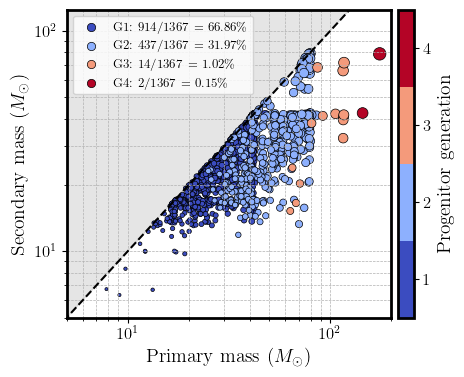

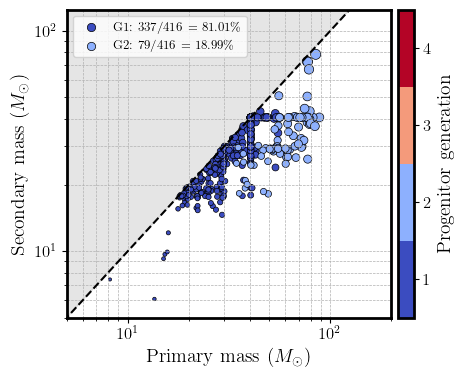

In [43]:
# Show m1-m2 for models 149 (colossus) and 146 for comparison
m1m2(cmcModels[149])
m1m2(cmcModels[146])

Read in VCC galaxies and their distance. Then read in Virgo GCs, calculating mass and rh from observational parameters. Crossmatch with VCC galaxy distances to help calculate rh.

In [17]:
vccGalaxies = {}

fileParams = {
    0: ("vccId", int),
    1: ("m-M", float)
}
# Read in VCC galaxies to crossmatch distance later
for line in readFile("virgo/VCC.dat", fileParams):
    modulus = line["m-M"]
    if modulus != None:
        distance = 10 ** ((modulus + 5) / 5) # Distance modulus in pc
    else:
        distance = 1.65e7 # If no distance modulus listed, just assume M87 distance
    vccGalaxies[line["vccId"]] = VirgoGalaxy(line["vccId"], distance)
    
    
virgoGCs = {}

# Color interpolation table (Table 3 of https://arxiv.org/pdf/astro-ph/0405188.pdf)
g_z_arr = [0.851, 0.907, 1.243, 1.425, 1.588, 1.897]
V_z_arr = [0.493, 0.512, 0.763, 0.901, 1.022, 1.257]

fileParams = {
    0: ("gcId", int),
    1: ("vccId", int),
    3: ("mz", float),
    4: ("mg", float),
    5: ("rhAS", float)
}
# Read in Virgo GCs
for line in readFile("virgo/Virgo_GCs.dat", fileParams):
    vccGalaxy = vccGalaxies[line["vccId"]]  # Get VCC galaxy for distance to GC
    mz = line["mz"]
    mg = line["mg"]
    rhAS = line["rhAS"]
    
    c_v = np.interp(mg - mz, g_z_arr, V_z_arr)
    DM = 31.03  # Distance Modulus
    Mv = 4.84  # V-band mag of sun
    M_to_L = 1.45  # V-band mass to light ratio (use 1.45 as for galactic GCs - McLaughlin 2000)
    mass = M_to_L * 10 ** (-0.4 * (mz - DM - Mv + c_v))
    if np.log10(mass) > 6.8: continue  # Filter out clusters which exceed colossus' initial mass
    rh = rhAS * 4.84814e-6 * vccGalaxy.distance  # Convert from arcsec to pc 
    
    gcId = line["gcId"]
    virgoGCs[gcId] = VirgoCluster(gcId, mass, rh, vccGalaxy)

Plot Virgo GCs and CMC models in mass-rh parameter space. Assign each CMC model a random color, and color each Virgo GC based on its closest counterpart in mass-rh space, to demonstrate coverage of distance function.

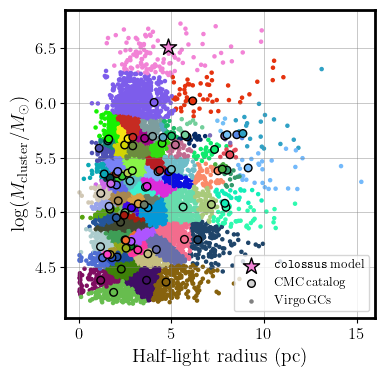

In [46]:
# Equation 7 - Mass-rh distance function
def distance(virgoCluster, cmcModel, C=10):
    massDistance = (C * (np.log10(cmcModel.mass / virgoCluster.mass))) ** 2
    rhDistance = (cmcModel.rh - virgoCluster.rh) ** 2
    return massDistance + rhDistance

# To demonstrate distance function, give every CMC model a random color, and color Virgo GCs by closest CMC
for model in cmcModels.values():
    model.normColor = (random.uniform(0,1),random.uniform(0,1),random.uniform(0,1))
for cluster in virgoGCs.values():
    cluster.closestColor = min(cmcModels.values(), key=lambda model:distance(cluster, model)).normColor
    
plt.figure(figsize=(4,4))

# Scatter virgo GCs and CMC models in log M-rh space. Separate marker for colossus
plt.scatter(cmcModels[149].rh, np.log10(cmcModels[149].mass), marker="*", facecolor=cmcModels[149].normColor, s=150, edgecolor='black', zorder=2, label=r"\texttt{colossus} model")
plt.scatter([model.rh for model in cmcModels.values() if model.id != 149], np.log10([model.mass for model in cmcModels.values() if model.id != 149]), c=[model.normColor for model in cmcModels.values() if model.id != 149], edgecolor='black', s=30, zorder=2)
plt.scatter([cluster.rh for cluster in virgoGCs.values()], np.log10([cluster.mass for cluster in virgoGCs.values()]), c=[cluster.closestColor for cluster in virgoGCs.values()], s=5)

plt.scatter(None,None,edgecolor='black',s=30, label=r'$\rm{CMC\,catalog}$',zorder=-1,facecolor='lightgrey')
plt.scatter(None,None,s=5,label=r'\rm{Virgo\,GCs}',zorder=-1,facecolor='grey')

plt.grid(color='gray', lw=0.6, alpha=0.5, ls='-')

plt.ylabel(r"$\log (M_{\mathrm{cluster}}/M_\odot)$")
plt.xlabel("Half-light radius (pc)")
plt.legend(fontsize=9, loc=4)
plt.show()

Predict total merger populations and 2G+ merger populations for Virgo GCs based on weighted average of 5 closest CMC models. Plot mass-rh parameter space again, but color by merger populations instead. Plot constant merger population curves.

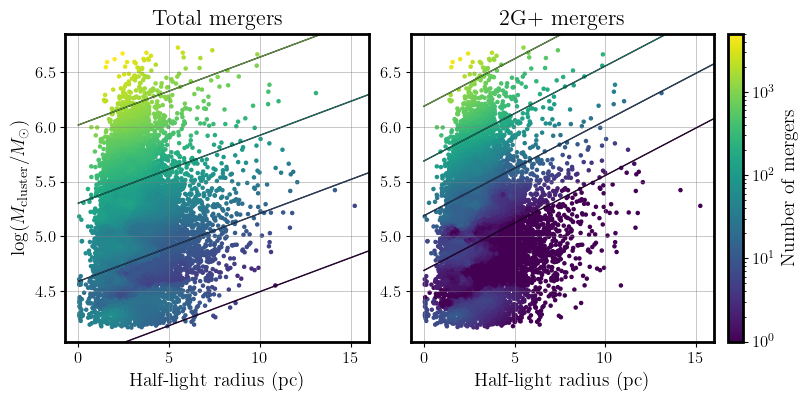

In [19]:
# Equation 9 - Predict total merger populations for a Virgo GC by scaling off a CMC model
def predictTotalMergers(virgoCluster, cmcModel, massPower=1.4, rhDecay=0.2):
    cmcMergers = len(cmcModel.mergers)
    massTerm = (virgoCluster.mass / cmcModel.mass) ** massPower
    e = 2.71828
    rhTerm = e ** (-rhDecay * (virgoCluster.rh - cmcModel.rh))
    
    return cmcMergers * massTerm * rhTerm

# Same thing but for 2G+ mergers
def predictHighGenMergers(virgoCluster, cmcModel, massPower=2.0, rhDecay=0.4):
    cmcMergers = len([merger for merger in cmcModel.mergers if merger.gen >= 2])
    massTerm = (virgoCluster.mass / cmcModel.mass) ** massPower
    e = 2.71828
    rhTerm = e ** (-rhDecay * (virgoCluster.rh - cmcModel.rh))
    
    return cmcMergers * massTerm * rhTerm

# Equation 10 - Get the 5 closest CMC models and take a weighted average of the BBH predictions
for virgoCluster in virgoGCs.values():
    closestCMCModels = sorted(cmcModels.values(), key=lambda model:distance(virgoCluster, model))[:5]
    minDistance = distance(virgoCluster, closestCMCModels[0]) # d_1
    
    totalWeight = 0
    weightedTotal = 0
    weightedHighGen = 0
    
    for model in closestCMCModels:
        modelWeight = minDistance / distance(virgoCluster, model) # d_1/d_n
        weightedTotal += modelWeight * predictTotalMergers(virgoCluster, model)
        weightedHighGen += modelWeight * predictHighGenMergers(virgoCluster, model)
        totalWeight += modelWeight
    
    virgoCluster.predictedMergers = weightedTotal / totalWeight
    virgoCluster.predictedHighGen = weightedHighGen / totalWeight
    
    
vmin=1
norm = mcolors.LogNorm(vmin=vmin,vmax=5000)

def plotConstantCurves(vals, normModel, normMergerCount, massPower, rhDecay):
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    # Plot constant N_bbh curves by scaling off of CMC model
    for constVal in vals:
        r = np.linspace(0,16,1000)
        # Expressing Equation 9 in terms of rh, Nbbh
        m = np.log10(normModel.mass * ((constVal / normMergerCount) * np.exp(rhDecay * (r - normModel.rh))) ** (1 / massPower))
        plt.plot(r, m, color="black", lw=1)
        plt.plot(r, m, color=plt.cm.viridis(norm(constVal)), lw=0.5)
    # Reset x and ylim
    plt.xlim(xlim)
    plt.ylim(ylim)
    
# Scatter log M-rh space for Virgo GCs as before, but instead color by BBH merger populations
fig,axes = plt.subplots(1,2,figsize=(9,4))

plt.subplot(1,2,1)
rv = [cluster.rh for cluster in virgoGCs.values()]
mass = np.log10([cluster.mass for cluster in virgoGCs.values()])
mergers = [cluster.predictedMergers if cluster.predictedMergers != 0 else vmin for cluster in virgoGCs.values()]
scatter = plt.scatter(rv, mass, c=mergers, s=5, norm=norm)

plotConstantCurves([1,10,100,1000], cmcModels[103], len(cmcModels[103].mergers), 1.4, 0.2)

plt.ylabel(r'$\log (M_{\rm cluster}/M_\odot)$')
plt.xlabel('Half-light radius (pc)')
plt.grid(color='gray', lw=0.6, alpha=0.5, ls='-')
plt.title("Total mergers")


plt.subplot(1,2,2)
rv = [cluster.rh for cluster in virgoGCs.values()]
mass = np.log10([cluster.mass for cluster in virgoGCs.values()])
mergers = [cluster.predictedHighGen if cluster.predictedHighGen != 0 else vmin for cluster in virgoGCs.values()]
scatter = plt.scatter(rv, mass, c=mergers, s=5, norm=norm)

plotConstantCurves([1,10,100,1000], cmcModels[104], len([m for m in cmcModels[104].mergers if m.gen >= 2]), 2.0, 0.4)

plt.grid(color='gray', lw=0.6, alpha=0.5, ls='-')
plt.xlabel('Half-light radius (pc)')
plt.title("2G+ mergers")

plt.subplots_adjust(wspace=0.14)

cbar = fig.colorbar(scatter, ax=axes, orientation="vertical", fraction=0.05, pad=0.02)
cbar.set_label("Number of mergers")

plt.show()

Plot cumulative cluster mass function of Virgo GCs, and compare this to CMF weighted by both total merger population and high-gen merger population. Find the 50% threshold for all three curves.

50% threshold for CMF: log M=5.12
50% threshold for BBH-weighted CMF: log M=5.79, heaviest 8.38%
50% threshold for 2G+ weighted CMF: log M=6.00, heaviest 3.52%


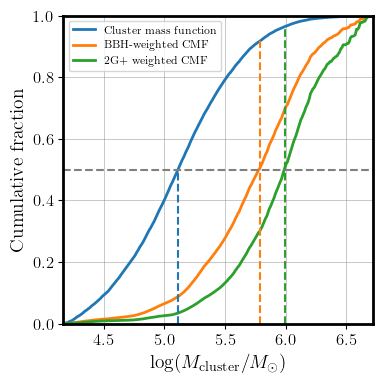

In [20]:
# Plot cumulative cluster mass function, alongside BBH-weighted and 2G+ weighted CMF

plt.figure(figsize=(4,4))

minVirgoMass = min([np.log10(cluster.mass) for cluster in virgoGCs.values()])
maxVirgoMass = max([np.log10(cluster.mass) for cluster in virgoGCs.values()])

bins = np.arange(minVirgoMass, maxVirgoMass, 0.01)
cmf,bbhCmf,highGenCmf = np.zeros(len(bins)), np.zeros(len(bins)), np.zeros(len(bins))

for cluster in virgoGCs.values():
    logMass = np.log10(cluster.mass)
    binIndex = np.digitize(logMass, bins) - 1
    
    cmf[binIndex] += 1
    bbhCmf[binIndex] += cluster.predictedMergers
    highGenCmf[binIndex] += cluster.predictedHighGen

# Convert histogram to cumulative
for binIndex in range(1, len(bins)):
    cmf[binIndex] = cmf[binIndex] + cmf[binIndex - 1]
    bbhCmf[binIndex] = bbhCmf[binIndex] + bbhCmf[binIndex - 1]
    highGenCmf[binIndex] = highGenCmf[binIndex] + highGenCmf[binIndex - 1]

# Normalize histogram
for binIndex in range(len(bins)):
    cmf[binIndex] /= cmf[-1]
    bbhCmf[binIndex] /= bbhCmf[-1]
    highGenCmf[binIndex] /= highGenCmf[-1]

cmfColor = "tab:blue"
bbhColor = "tab:orange"
highGenColor = "tab:green"
    
plt.plot(bins, cmf, lw=2, label="Cluster mass function", color=cmfColor)
plt.plot(bins, bbhCmf, lw=2, label="BBH-weighted CMF", color=bbhColor)
plt.plot(bins, highGenCmf, lw=2, label="2G+ weighted CMF", color=highGenColor)
plt.legend(loc=2, fontsize=8)

plt.axhline(0.5, color='gray', ls='--')

cmfHalfIndex = bisect.bisect(cmf, 0.5)
print(f"50% threshold for CMF: log M={'{:.2f}'.format(bins[cmfHalfIndex])}")
plt.axvline(bins[cmfHalfIndex],0,0.5, ls='--', color=cmfColor)

bbhHalfIndex = bisect.bisect(bbhCmf, 0.5)
print(f"50% threshold for BBH-weighted CMF: log M={'{:.2f}'.format(bins[bbhHalfIndex])}, heaviest {'{:.2f}'.format(100 * (1-cmf[bbhHalfIndex]))}%")
plt.axvline(bins[bbhHalfIndex],0,cmf[bbhHalfIndex], ls='--', color=bbhColor)

highGenHalfIndex = bisect.bisect(highGenCmf, 0.5)
print(f"50% threshold for 2G+ weighted CMF: log M={'{:.2f}'.format(bins[highGenHalfIndex])}, heaviest {'{:.2f}'.format(100 * (1-cmf[highGenHalfIndex]))}%")
plt.axvline(bins[highGenHalfIndex],0,cmf[highGenHalfIndex], ls='--', color=highGenColor)


plt.ylabel("Cumulative fraction")
plt.xlabel(r"$\log (M_{\rm cluster}/M_\odot)$")

plt.ylim(0,1)
plt.xlim(minVirgoMass,maxVirgoMass)
plt.grid(color='gray', lw=0.6, alpha=0.5, ls='-')

plt.show()

Portable function to predict merger counts of any GC, given its mass and rh. This function can be used in other notebooks without any dependencies, as it contains all relevant CMC data hardcoded in the `cmcData` variable.

In [28]:
def predictMergerCounts(clusterMass, clusterRh, highGen=False):
    """
    Predict merger count for an arbitrary globular cluster
    given its cluster mass (M_sun) and half-light radius (pc),
    as described in Mai et al. (2025).
    
    Defaults to total merger populations; for high-gen (2G+)
    merger populations, set optional highGen flag to True.
    """

    cmcData = {3: {'mass': 127133.20296545581, 'rh': 2.133, 'numMergers': 71, 'numHighGen': 14}, 7: {'mass': 148962.84296246798, 'rh': 1.19369660956, 'numMergers': 132, 'numHighGen': 21}, 8: {'mass': 384845.48807007377, 'rh': 1.10481, 'numMergers': 360, 'numHighGen': 84}, 14: {'mass': 18545.155625063762, 'rh': 1.88512275148, 'numMergers': 65, 'numHighGen': 10}, 15: {'mass': 193342.67239332228, 'rh': 2.76298434318, 'numMergers': 154, 'numHighGen': 22}, 17: {'mass': 23922.77487914178, 'rh': 1.1897096444, 'numMergers': 16, 'numHighGen': 0}, 18: {'mass': 81136.56660988044, 'rh': 2.25587182168, 'numMergers': 60, 'numHighGen': 6}, 19: {'mass': 205983.94500942796, 'rh': 1.68950441088, 'numMergers': 141, 'numHighGen': 22}, 20: {'mass': 449451.2832620765, 'rh': 1.57462, 'numMergers': 361, 'numHighGen': 85}, 25: {'mass': 23023.44787834257, 'rh': 4.70730499193, 'numMergers': 24, 'numHighGen': 2}, 26: {'mass': 55904.20141370607, 'rh': 2.49923587283, 'numMergers': 58, 'numHighGen': 8}, 27: {'mass': 213875.17061913825, 'rh': 2.34341118083, 'numMergers': 150, 'numHighGen': 19}, 29: {'mass': 23922.15465992159, 'rh': 3.65770480237, 'numMergers': 21, 'numHighGen': 5}, 30: {'mass': 88978.97156162922, 'rh': 2.02972411126, 'numMergers': 55, 'numHighGen': 8}, 31: {'mass': 223819.5100769051, 'rh': 1.37991, 'numMergers': 147, 'numHighGen': 22}, 32: {'mass': 466841.1904868912, 'rh': 1.62128, 'numMergers': 381, 'numHighGen': 93}, 38: {'mass': 39017.608838078515, 'rh': 2.07042526475, 'numMergers': 32, 'numHighGen': 4}, 39: {'mass': 177414.3000341118, 'rh': 2.03923, 'numMergers': 108, 'numHighGen': 15}, 40: {'mass': 404338.90119976026, 'rh': 2.91095, 'numMergers': 289, 'numHighGen': 50}, 42: {'mass': 48453.82024982042, 'rh': 1.17994504091, 'numMergers': 34, 'numHighGen': 2}, 43: {'mass': 182865.1893716386, 'rh': 1.73627, 'numMergers': 95, 'numHighGen': 12}, 44: {'mass': 411629.86617546255, 'rh': 2.47914, 'numMergers': 258, 'numHighGen': 44}, 49: {'mass': 30238.578732905622, 'rh': 2.2974276471, 'numMergers': 7, 'numHighGen': 1}, 50: {'mass': 99226.73852108844, 'rh': 2.49795681754, 'numMergers': 47, 'numHighGen': 5}, 51: {'mass': 227965.08527560133, 'rh': 2.64893560025, 'numMergers': 107, 'numHighGen': 12}, 52: {'mass': 473603.55503086053, 'rh': 3.55503, 'numMergers': 284, 'numHighGen': 46}, 53: {'mass': 38489.49198652915, 'rh': 1.79699310925, 'numMergers': 17, 'numHighGen': 1}, 54: {'mass': 106697.36929744965, 'rh': 1.69099803581, 'numMergers': 36, 'numHighGen': 0}, 55: {'mass': 225250.39950858985, 'rh': 2.039877032, 'numMergers': 111, 'numHighGen': 13}, 56: {'mass': 469611.8273088876, 'rh': 2.66453, 'numMergers': 300, 'numHighGen': 55}, 61: {'mass': 45257.970512620224, 'rh': 3.18972630981, 'numMergers': 11, 'numHighGen': 1}, 62: {'mass': 93995.75732176765, 'rh': 2.45424301141, 'numMergers': 38, 'numHighGen': 0}, 63: {'mass': 239831.9072618582, 'rh': 2.89153, 'numMergers': 114, 'numHighGen': 17}, 64: {'mass': 493382.6526856175, 'rh': 3.98294, 'numMergers': 290, 'numHighGen': 45}, 65: {'mass': 41039.91160808768, 'rh': 1.69605448278, 'numMergers': 16, 'numHighGen': 1}, 66: {'mass': 113333.93536424554, 'rh': 1.64283099219, 'numMergers': 41, 'numHighGen': 1}, 67: {'mass': 235815.65301967954, 'rh': 2.10844281018, 'numMergers': 102, 'numHighGen': 12}, 68: {'mass': 483743.5995018761, 'rh': 2.91985932621, 'numMergers': 271, 'numHighGen': 48}, 74: {'mass': 38410.29297780812, 'rh': 1.29135879048, 'numMergers': 30, 'numHighGen': 2}, 75: {'mass': 169420.68108887106, 'rh': 3.60017, 'numMergers': 61, 'numHighGen': 5}, 76: {'mass': 413453.3423480317, 'rh': 5.20908, 'numMergers': 192, 'numHighGen': 19}, 78: {'mass': 41119.361174489095, 'rh': 1.55047136308, 'numMergers': 21, 'numHighGen': 1}, 79: {'mass': 172254.80045525715, 'rh': 3.68573, 'numMergers': 57, 'numHighGen': 4}, 80: {'mass': 427151.76123987953, 'rh': 4.49308018156, 'numMergers': 153, 'numHighGen': 16}, 85: {'mass': 49065.01417360517, 'rh': 2.81101901582, 'numMergers': 10, 'numHighGen': 0}, 86: {'mass': 110143.96496361372, 'rh': 3.73428143502, 'numMergers': 27, 'numHighGen': 2}, 87: {'mass': 235080.6889252748, 'rh': 4.8565, 'numMergers': 68, 'numHighGen': 6}, 88: {'mass': 488487.10887709004, 'rh': 5.83819, 'numMergers': 174, 'numHighGen': 19}, 89: {'mass': 46956.23123560111, 'rh': 2.55671252153, 'numMergers': 6, 'numHighGen': 0}, 90: {'mass': 109772.74037124676, 'rh': 2.84573919325, 'numMergers': 24, 'numHighGen': 1}, 91: {'mass': 235026.5451523088, 'rh': 4.27720715551, 'numMergers': 64, 'numHighGen': 4}, 92: {'mass': 483579.8849139027, 'rh': 4.54228, 'numMergers': 153, 'numHighGen': 15}, 97: {'mass': 54058.20701988415, 'rh': 2.82680320094, 'numMergers': 7, 'numHighGen': 0}, 98: {'mass': 119370.45584440176, 'rh': 3.21011, 'numMergers': 23, 'numHighGen': 1}, 99: {'mass': 246144.13551149602, 'rh': 4.99702376435, 'numMergers': 67, 'numHighGen': 4}, 100: {'mass': 508050.9628252397, 'rh': 5.73594, 'numMergers': 166, 'numHighGen': 24}, 101: {'mass': 55565.32212875018, 'rh': 2.53818108002, 'numMergers': 5, 'numHighGen': 0}, 102: {'mass': 117043.15682987821, 'rh': 3.53173856461, 'numMergers': 22, 'numHighGen': 1}, 103: {'mass': 240990.97538361265, 'rh': 4.36483448437, 'numMergers': 54, 'numHighGen': 2}, 104: {'mass': 495848.1008416838, 'rh': 5.00376, 'numMergers': 153, 'numHighGen': 14}, 112: {'mass': 335329.82097564946, 'rh': 8.14479, 'numMergers': 43, 'numHighGen': 3}, 116: {'mass': 374641.17594059266, 'rh': 7.31788326483, 'numMergers': 91, 'numHighGen': 5}, 121: {'mass': 41691.68017858658, 'rh': 3.73040949602, 'numMergers': 6, 'numHighGen': 0}, 122: {'mass': 110999.05252734723, 'rh': 7.93661851717, 'numMergers': 13, 'numHighGen': 1}, 123: {'mass': 242535.2348039509, 'rh': 7.99356196952, 'numMergers': 40, 'numHighGen': 1}, 124: {'mass': 510904.9932763226, 'rh': 8.5141337614, 'numMergers': 80, 'numHighGen': 4}, 125: {'mass': 45578.98140950872, 'rh': 4.18771760326, 'numMergers': 8, 'numHighGen': 0}, 126: {'mass': 111729.8310186414, 'rh': 5.62521099272, 'numMergers': 13, 'numHighGen': 0}, 127: {'mass': 239093.37649227027, 'rh': 7.50434646379, 'numMergers': 45, 'numHighGen': 3}, 128: {'mass': 497791.4588137581, 'rh': 7.86639617103, 'numMergers': 95, 'numHighGen': 9}, 133: {'mass': 56519.451053941295, 'rh': 5.69792118886, 'numMergers': 6, 'numHighGen': 0}, 134: {'mass': 120752.28909125619, 'rh': 7.87333510061, 'numMergers': 14, 'numHighGen': 0}, 135: {'mass': 253869.60592937266, 'rh': 9.12965281632, 'numMergers': 29, 'numHighGen': 1}, 136: {'mass': 524320.4092022832, 'rh': 8.84570311559, 'numMergers': 91, 'numHighGen': 7}, 137: {'mass': 56002.843722283775, 'rh': 6.41721575215, 'numMergers': 8, 'numHighGen': 0}, 138: {'mass': 117754.28880808006, 'rh': 7.14900580221, 'numMergers': 15, 'numHighGen': 0}, 139: {'mass': 247684.77340998471, 'rh': 7.73414, 'numMergers': 38, 'numHighGen': 0}, 140: {'mass': 510551.8322716015, 'rh': 7.99088257952, 'numMergers': 94, 'numHighGen': 4}, 145: {'mass': 1009193.1312014527, 'rh': 4.06327007592, 'numMergers': 744, 'numHighGen': 190}, 146: {'mass': 1040557.9310980255, 'rh': 6.14326, 'numMergers': 416, 'numHighGen': 79}, 149: {'mass': 3265123.5128139607, 'rh': 4.7988, 'numMergers': 1367, 'numHighGen': 453}}
    # Change the distant constant here. This controls the relative weighting of delta-log M and delta-rh for the distance function.
    distanceConstant = 10
    def distance(cmcMass, cmcRh):
        massTerm = (distanceConstant * np.log10(clusterMass / cmcMass)) ** 2
        rhTerm = (clusterRh - cmcRh) ** 2
        return massTerm + rhTerm
    
    numClosestModels = 5  # Change the number of CMC models to weight here
    closestCMCmodels = sorted(cmcData.values(), key=lambda model : distance(model['mass'], model['rh']))[:numClosestModels]
    minDistance = distance(closestCMCmodels[0]['mass'], closestCMCmodels[0]['rh'])
    
    # Change the mass power and rh decay constant here. First value is for high gen mergers, second value is for total mergers
    massPower = 2.0 if highGen else 1.4
    rhDecay = 0.4 if highGen else 0.2
    
    # Equation 10 - take a weighted average of the predictions of each close CMC model
    totalWeight = 0
    weightedTotal = 0
    
    for model in closestCMCmodels:
        modelWeight = minDistance / distance(model['mass'], model['rh']) 
        totalWeight += modelWeight
        numMergers = model['numHighGen'] if highGen else model['numMergers']
        
        massTerm = (clusterMass / model['mass']) ** massPower
        rhTerm = 2.7182 ** (-rhDecay * (clusterRh - model['rh']))
        weightedTotal += modelWeight * numMergers * massTerm * rhTerm
    
    return weightedTotal / totalWeight